In [13]:
import functools
import importlib
import itertools
import pickle
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import NearestNeighbors
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.model_selection
import sklearn.multiclass
from sklearn.neural_network import MLPRegressor, MLPClassifier
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
import scipy.stats as sps
%matplotlib inline

In [ ]:
def pseudo_R2(y, logprobs):
    L_w = np.sum(logprobs[np.arange(y.size),y])
    L_0 = np.sum(logprobs[np.arange(y.size),sps.mode(y)[0][0]])
    return 1 - L_w/L_0

In [3]:
# df = pd.read_csv('./boston.csv')
# X = df.iloc[:,:-1].values
# y = df.iloc[:,-1].values

In [161]:
hid = 40
m = 10000
n = 10
W1 = np.random.randn(n, hid)
b1 = np.random.randn(hid)
w2 = np.random.randn(hid)
b2 = np.random.randn(1)
X = np.random.randn(m, n)
Z = np.tanh(X @ W1 + b1)

In [162]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [163]:
# y = Z @ w2 + b2
# y = y + np.random.randn(y.size)
p = sigmoid(Z @ w2 + b2)
y = sps.bernoulli.rvs(p)

In [167]:
def get_loader(X, y, batch_size=64):
    data = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y).float().view(-1,1))
    data_loader = torch.utils.data.DataLoader(data, 
                                               batch_size=batch_size)
    return data_loader

def train_epoch(model, optimizer, train_loader, criterion):
    model.train()
    for X, y in train_loader:
        out = model(X)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate_loss(loader, model):
    with torch.no_grad():
        model.eval()
        loss = 0
        k = 0
        for X, y in loader:
            k += y.shape[0]
            out = model(X)
            loss += criterion(out, y.float()).numpy() 
        loss /= k
    return loss

def train(model, opt, train_loader, test_loader, criterion, n_epochs, verbose=True):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion)
        train_loss = evaluate_loss(train_loader, model)
        val_loss = evaluate_loss(test_loader, model)
        train_log.append(train_loss)
        val_log.append(val_loss)
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,')
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss))
            
    return train_log, val_log

class DenseNet(nn.Module, classif = ):
    def __init__(self, in_ch, hid_ch):
        super(DenseNet, self).__init__()
        self.linear1 = nn.Linear(in_ch, hid_ch)
        self.linear2 = nn.Linear(hid_ch, 1)
        self.nonlin = nn.PReLU()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        Z = self.nonlin(self.linear1(x))
        out = self.linear2(Z)
        return self.sig(out)
    
    def get_z(self,x):
        return self.nonlin(self.linear1(x))

In [168]:
train_loader = get_loader(X, y) 
test_loader = get_loader(X, y)

In [170]:
B = 10
k = 40
r2s = np.zeros((B,k-2))
for hid in tqdm(range(2,k)):
    criterion = nn.MSELoss()
    for j in range(B):
        p = np.random.permutation(m)[:m//3]
        train_loader = get_loader(X[p], y[p]) 
        
        model = DenseNet(10, hid)
        optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
        train_log, test_log = train(model, optimizer, train_loader, test_loader, criterion, 10, verbose=False)
        a = model.get_z(torch.FloatTensor(X[p])).detach().numpy()
        
        linreg = LinearRegression()
        linreg.fit(a,y)
        pred = linreg.predict(a)

        r2s.append(r2_score(y,pred))

HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

RuntimeError: size mismatch, m1: [64 x 10], m2: [13 x 2] at /opt/conda/conda-bld/pytorch_1532579245307/work/aten/src/TH/generic/THTensorMath.cpp:2070

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(np.arange(2,k), r2s.mean(0), r2s.std(0))
plt.xlabel('Number of neurons')
plt.ylabel('R^2')
_=plt.title('Dependence of R^2 on neurons number with subsampling')

In [237]:
B = 2
k = 200
start = 40
step = 10
neurons = np.arange(start,k,step)
r2s = np.zeros((B,neurons.size))
for hid in tqdm(neurons): 
    criterion = nn.BCELoss()
    
    for j in range(B):
        p = np.random.permutation(m)[:m//3]
        
        train_loader = get_loader(X[p], y[p]) 
        
        model = DenseNet(10, hid)
        optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
        train_log, test_log = train(model, optimizer, train_loader, test_loader, criterion, 10, verbose=False)
        a = model.get_z(torch.FloatTensor(X[p])).detach().numpy()

        logreg = LogisticRegression()
        logreg.fit(a,y[p])
        
        logprobs = logreg.predict_log_proba(a)
        r2s[j,(hid-start)//step] = pseudo_R2(y[p],logprobs)

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

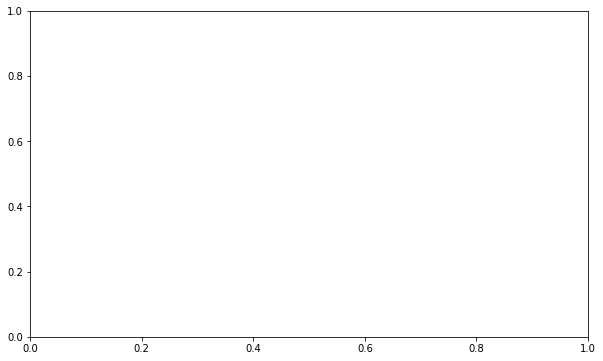

In [229]:
plt.figure(figsize=(10,6))
plt.errorbar(snp.arange(r2s.mean), r2s.mean(0), r2s.std(0))
plt.xlabel('Number of neurons')
plt.ylabel('Pseudo-R^2')
_=plt.title('Dependence of R^2 on neurons number with subsampling')